In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Verify that there ar not complex numbers and that the matrix is symmetrical

In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

0

### Visualization of the covariance matrix:

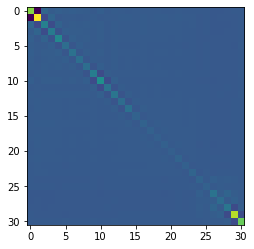

In [4]:
plt.imshow(syscov)

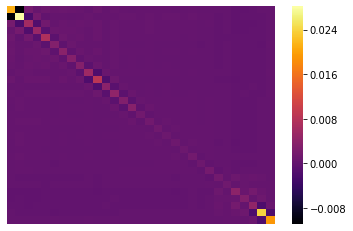

In [5]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')
plt.savefig("original_cov_binned_JLA.png", dpi=200)

In [6]:
np.min(np.abs(syscov)), np.max(np.abs(syscov)) #checking non-negatives in the diagonal

(1.695011341e-07, 0.02815552265)

### Generate a data set with covariance matrix from the original plus gaussian noise

In [7]:
numMatrix = 1000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal() 
#     val, vec = np.linalg.eigh(syscov)
#     D = np.diag(val)    
#     covset[i] = (vec+0.0001*err) @ (D) @ (vec+0.0001*err).T
    err = np.random.normal(size=syscov.shape) 
    covset[i] = syscov + 0.001 * err
    covset_noise[i] = syscov + 0.05 * err
#     covset_noise[i] = syscov + 0.001*err

 Generating 1000 matrix 

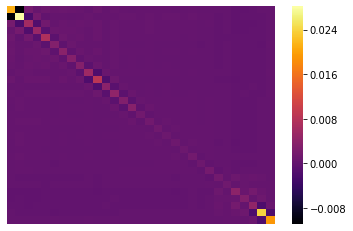

In [8]:
val, vec = np.linalg.eigh(syscov)
D = np.diag(val)
new = (vec+0.1) @ (D) @ (vec+0.1).T
sns.heatmap(pd.DataFrame(syscov), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

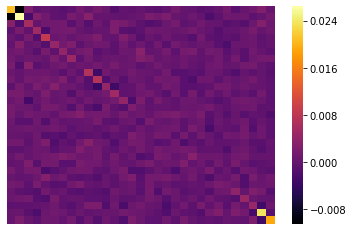

In [9]:
sns.heatmap(pd.DataFrame(covset[10]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

In [10]:
print(np.shape(covset))

(1000, 31, 31)


(1000, 31, 31)


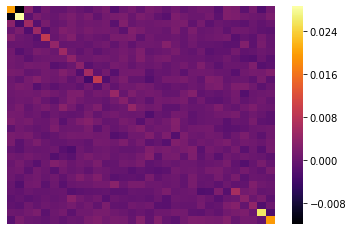

In [11]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))



In [12]:
# input_cov = Input(shape=(31, 31, 1))

# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img = tf.keras.Input(shape=(31*31,))
# begin encoder
x = layers.Dense(100, activation='tanh')(input_img)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
encoded = layers.Dense(encoding_dim, activation='tanh')(x)
x = layers.Dropout(0.2)(encoded)
#begin decoder
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
# x = layers.Dropout(0.2)
decoded = layers.Dense(31*31, activation='linear')(x)


# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               96200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                3131      
_________________________________________________________________
dropout_2 (Dropout)          (None, 31)               

In [13]:
encoder = tf.keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))

decoder_layer1 = autoencoder.layers[-5]
decoder_layer2 = autoencoder.layers[-4]
decoder_layer3 = autoencoder.layers[-3]
decoder_layer4 = autoencoder.layers[-2]
decoder_layer5 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, 
                decoder_layer5(decoder_layer4(decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))))

In [14]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=10, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=300,
                batch_size=32,
                shuffle=True,
                validation_data=(covset_noise_test, covset_test),
                callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/300
25/25 [==============================] - 0s 7ms/step - loss: 6.7281e-04 - val_loss: 6.7339e-05
Epoch 2/300
25/25 [==============================] - 0s 3ms/step - loss: 1.4080e-04 - val_loss: 1.9655e-05
Epoch 3/300
25/25 [==============================] - 0s 3ms/step - loss: 6.8861e-05 - val_loss: 1.0179e-05
Epoch 4/300
25/25 [==============================] - 0s 3ms/step - loss: 4.4329e-05 - val_loss: 6.6569e-06
Epoch 5/300
25/25 [==============================] - 0s 3ms/step - loss: 3.2911e-05 - val_loss: 4.8449e-06
Epoch 6/300
25/25 [==============================] - 0s 3ms/step - loss: 2.6112e-05 - val_loss: 3.7180e-06
Epoch 7/300
25/25 [==============================] - 0s 3ms/step - loss: 2.0333e-05 - val_loss: 2.9402e-06
Epoch 8/300
25/25 [==============================] - 0s 3ms/step - loss: 1.6946e-05 - val_loss: 2.4638e-06
Epoch 9/300
25/25 [==============================] - 0s 3ms/step - loss: 1.4311e-05 - val_loss: 2.1882e-06
Epoch 10/300
25/25 [=================

Epoch 77/300
25/25 [==============================] - 0s 2ms/step - loss: 1.2902e-06 - val_loss: 1.0398e-06
Epoch 78/300
25/25 [==============================] - 0s 3ms/step - loss: 1.2867e-06 - val_loss: 1.0363e-06
Epoch 79/300
25/25 [==============================] - 0s 3ms/step - loss: 1.2743e-06 - val_loss: 1.0369e-06
Epoch 80/300
25/25 [==============================] - 0s 2ms/step - loss: 1.2681e-06 - val_loss: 1.0383e-06
Epoch 81/300
25/25 [==============================] - 0s 2ms/step - loss: 1.2581e-06 - val_loss: 1.0383e-06
Epoch 82/300
25/25 [==============================] - 0s 2ms/step - loss: 1.2644e-06 - val_loss: 1.0347e-06
Epoch 83/300
25/25 [==============================] - 0s 3ms/step - loss: 1.2448e-06 - val_loss: 1.0394e-06


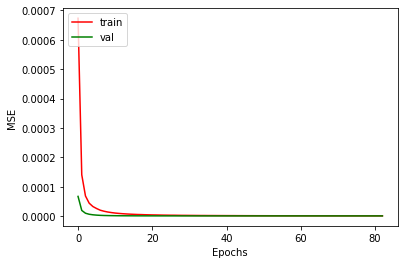

In [15]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLA.png', dpi=200)

In [16]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

1.0313312941434558e-06 1.2448244888219051e-06


In [17]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
np.min(encoded_imgs)

(200, 31)


-0.0033387311

(200, 961)


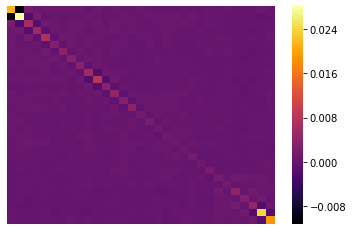

In [18]:
print(np.shape(decoded_imgs))

sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")
# this cov matrix work well within Bayesian inference
# np.savetxt("test.dat", decoded_imgs[0].reshape(31,31), delimiter= " ", header="#fake COV")


In [19]:
print(np.shape(decoded_imgs))

(200, 961)


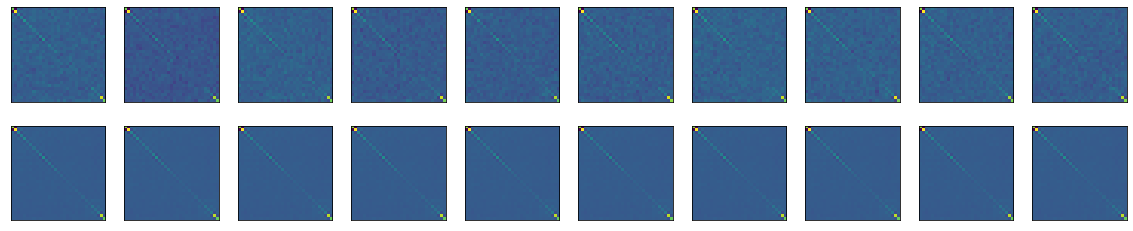

In [20]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(covset_test[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

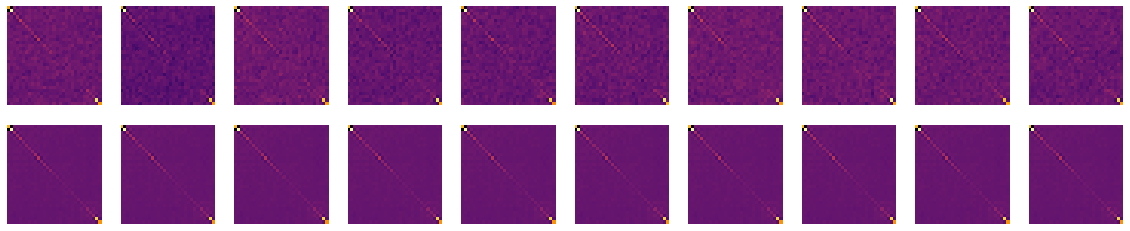

In [21]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
plt.savefig('predicted_covs_binned_jla.png', dpi=200)

### Now we train another neural network for z and $D_L(z)$

           z      $D_L$
0   0.010000  32.953887
1   0.011762  33.879003
2   0.013833  33.842141
3   0.016270  34.118567
4   0.019136  34.593446
5   0.022507  34.939027
6   0.026472  35.252096
7   0.031135  35.748502
8   0.036620  36.069788
9   0.043071  36.434570
10  0.050658  36.651111
11  0.059582  37.158014
12  0.070077  37.430173
13  0.082422  37.956616
14  0.096941  38.253254
15  0.114018  38.612869
16  0.134102  39.067851
17  0.157725  39.341402
18  0.185509  39.792144
19  0.218188  40.156535
20  0.256623  40.564956
21  0.301829  40.905288
22  0.354997  41.421417
23  0.417532  41.790923
24  0.491083  42.231461
25  0.577590  42.617047
26  0.679335  43.052731
27  0.799004  43.504151
28  0.939753  43.972573
29  1.105296  44.514088
30  1.300000  44.821867


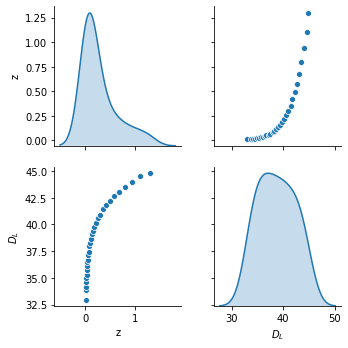

In [22]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
print(data.head(31))
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistbinnedJLA.png")

In [23]:
shuffle = [x for x in range(len(data.values)) if x%2 ==1]
comp = [x for x in range(len(data.values)) if x%2 ==0]
shuffle.extend(comp)

data = data.values[shuffle]

In [24]:
z = data[:,0]
dl = data[:,1:]

In [25]:
# scalerz = StandardScaler()
# # scalerz = MinMaxScaler(feature_range=(-1,1))
# # fit scaler on data
# scalerz.fit(z.reshape(-1,1))
# # apply transform
# z = scalerz.transform(z.reshape(-1,1))

In [26]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
dl_train, dl_test = np.split(dl, indx)

In [27]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.,
                                   patience=200,
                                   restore_best_weights=True)]

In [28]:
def model(input_z):
#     efirst = Dense(300, activation='relu', input_shape=(1,))(input_z)
#     x = Dense(50, activation='relu')(efirst)
#     x = Dense(50, activation='relu')(x)
#     x = Dense(50, activation='relu')(x)
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(50, activation='relu')(efirst)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(50, activation='relu')(x)


    elast = Dense(1, activation='linear')(x)
    return elast

batch_size = 32
epochs = 500
input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [29]:
model_train = neural_model.fit(z_train, dl_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, dl_test),
                                    callbacks=callbacks)

Epoch 1/500
1/1 [==============================] - 0s 94ms/step - loss: 1433.9310 - val_loss: 1784.2994
Epoch 2/500
1/1 [==============================] - 0s 15ms/step - loss: 1432.4224 - val_loss: 1781.2415
Epoch 3/500
1/1 [==============================] - 0s 16ms/step - loss: 1430.9225 - val_loss: 1778.3058
Epoch 4/500
1/1 [==============================] - 0s 16ms/step - loss: 1429.3861 - val_loss: 1775.3049
Epoch 5/500
1/1 [==============================] - 0s 15ms/step - loss: 1427.7305 - val_loss: 1772.1451
Epoch 6/500
1/1 [==============================] - 0s 16ms/step - loss: 1425.9059 - val_loss: 1768.5770
Epoch 7/500
1/1 [==============================] - 0s 16ms/step - loss: 1423.8470 - val_loss: 1764.5001
Epoch 8/500
1/1 [==============================] - 0s 19ms/step - loss: 1421.5309 - val_loss: 1759.8801
Epoch 9/500
1/1 [==============================] - 0s 23ms/step - loss: 1418.9486 - val_loss: 1754.7334
Epoch 10/500
1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 15ms/step - loss: 76.0049 - val_loss: 140.7980
Epoch 81/500
1/1 [==============================] - 0s 21ms/step - loss: 72.7526 - val_loss: 143.7768
Epoch 82/500
1/1 [==============================] - 0s 15ms/step - loss: 69.2084 - val_loss: 148.4318
Epoch 83/500
1/1 [==============================] - 0s 15ms/step - loss: 65.5846 - val_loss: 154.6086
Epoch 84/500
1/1 [==============================] - 0s 16ms/step - loss: 62.0832 - val_loss: 162.0906
Epoch 85/500
1/1 [==============================] - 0s 16ms/step - loss: 58.8761 - val_loss: 170.5733
Epoch 86/500
1/1 [==============================] - 0s 16ms/step - loss: 56.0884 - val_loss: 179.6543
Epoch 87/500
1/1 [==============================] - 0s 17ms/step - loss: 53.7880 - val_loss: 188.8414
Epoch 88/500
1/1 [==============================] - 0s 14ms/step - loss: 51.9812 - val_loss: 197.5799
Epoch 89/500
1/1 [==============================] - 0s 15ms/step - loss: 50.6167 - val_loss: 20

1/1 [==============================] - 0s 14ms/step - loss: 7.9718 - val_loss: 35.3084
Epoch 161/500
1/1 [==============================] - 0s 14ms/step - loss: 7.7712 - val_loss: 34.3053
Epoch 162/500
1/1 [==============================] - 0s 18ms/step - loss: 7.5766 - val_loss: 33.3391
Epoch 163/500
1/1 [==============================] - 0s 15ms/step - loss: 7.3879 - val_loss: 32.4124
Epoch 164/500
1/1 [==============================] - 0s 16ms/step - loss: 7.2049 - val_loss: 31.5263
Epoch 165/500
1/1 [==============================] - 0s 14ms/step - loss: 7.0273 - val_loss: 30.6807
Epoch 166/500
1/1 [==============================] - 0s 15ms/step - loss: 6.8550 - val_loss: 29.8745
Epoch 167/500
1/1 [==============================] - 0s 17ms/step - loss: 6.6877 - val_loss: 29.1055
Epoch 168/500
1/1 [==============================] - 0s 15ms/step - loss: 6.5253 - val_loss: 28.3707
Epoch 169/500
1/1 [==============================] - 0s 16ms/step - loss: 6.3677 - val_loss: 27.6669
Epoc

1/1 [==============================] - 0s 18ms/step - loss: 2.0978 - val_loss: 5.9902
Epoch 242/500
1/1 [==============================] - 0s 17ms/step - loss: 2.0774 - val_loss: 5.9124
Epoch 243/500
1/1 [==============================] - 0s 14ms/step - loss: 2.0571 - val_loss: 5.8356
Epoch 244/500
1/1 [==============================] - 0s 16ms/step - loss: 2.0369 - val_loss: 5.7600
Epoch 245/500
1/1 [==============================] - 0s 17ms/step - loss: 2.0168 - val_loss: 5.6860
Epoch 246/500
1/1 [==============================] - 0s 17ms/step - loss: 1.9968 - val_loss: 5.6138
Epoch 247/500
1/1 [==============================] - 0s 17ms/step - loss: 1.9768 - val_loss: 5.5436
Epoch 248/500
1/1 [==============================] - 0s 18ms/step - loss: 1.9569 - val_loss: 5.4755
Epoch 249/500
1/1 [==============================] - 0s 15ms/step - loss: 1.9370 - val_loss: 5.4094
Epoch 250/500
1/1 [==============================] - 0s 13ms/step - loss: 1.9172 - val_loss: 5.3454
Epoch 251/500


1/1 [==============================] - 0s 21ms/step - loss: 0.6869 - val_loss: 2.2752
Epoch 324/500
1/1 [==============================] - 0s 20ms/step - loss: 0.6758 - val_loss: 2.2426
Epoch 325/500
1/1 [==============================] - 0s 17ms/step - loss: 0.6647 - val_loss: 2.2106
Epoch 326/500
1/1 [==============================] - 0s 18ms/step - loss: 0.6540 - val_loss: 2.1788
Epoch 327/500
1/1 [==============================] - 0s 15ms/step - loss: 0.6429 - val_loss: 2.1466
Epoch 328/500
1/1 [==============================] - 0s 15ms/step - loss: 0.6321 - val_loss: 2.1150
Epoch 329/500
1/1 [==============================] - 0s 17ms/step - loss: 0.6219 - val_loss: 2.0815
Epoch 330/500
1/1 [==============================] - 0s 16ms/step - loss: 0.6115 - val_loss: 2.0483
Epoch 331/500
1/1 [==============================] - 0s 16ms/step - loss: 0.6014 - val_loss: 2.0153
Epoch 332/500
1/1 [==============================] - 0s 16ms/step - loss: 0.5917 - val_loss: 1.9824
Epoch 333/500


1/1 [==============================] - 0s 17ms/step - loss: 0.2155 - val_loss: 0.9429
Epoch 406/500
1/1 [==============================] - 0s 16ms/step - loss: 0.2136 - val_loss: 0.9372
Epoch 407/500
1/1 [==============================] - 0s 14ms/step - loss: 0.2117 - val_loss: 0.9318
Epoch 408/500
1/1 [==============================] - 0s 15ms/step - loss: 0.2098 - val_loss: 0.9259
Epoch 409/500
1/1 [==============================] - 0s 14ms/step - loss: 0.2080 - val_loss: 0.9198
Epoch 410/500
1/1 [==============================] - 0s 14ms/step - loss: 0.2063 - val_loss: 0.9141
Epoch 411/500
1/1 [==============================] - 0s 14ms/step - loss: 0.2046 - val_loss: 0.9087
Epoch 412/500
1/1 [==============================] - 0s 17ms/step - loss: 0.2030 - val_loss: 0.9002
Epoch 413/500
1/1 [==============================] - 0s 15ms/step - loss: 0.2016 - val_loss: 0.8947
Epoch 414/500
1/1 [==============================] - 0s 14ms/step - loss: 0.1999 - val_loss: 0.8893
Epoch 415/500


1/1 [==============================] - 0s 16ms/step - loss: 0.1139 - val_loss: 0.6499
Epoch 488/500
1/1 [==============================] - 0s 17ms/step - loss: 0.1132 - val_loss: 0.6468
Epoch 489/500
1/1 [==============================] - 0s 15ms/step - loss: 0.1125 - val_loss: 0.6441
Epoch 490/500
1/1 [==============================] - 0s 16ms/step - loss: 0.1119 - val_loss: 0.6429
Epoch 491/500
1/1 [==============================] - 0s 16ms/step - loss: 0.1112 - val_loss: 0.6416
Epoch 492/500
1/1 [==============================] - 0s 16ms/step - loss: 0.1106 - val_loss: 0.6398
Epoch 493/500
1/1 [==============================] - 0s 15ms/step - loss: 0.1099 - val_loss: 0.6389
Epoch 494/500
1/1 [==============================] - 0s 19ms/step - loss: 0.1093 - val_loss: 0.6383
Epoch 495/500
1/1 [==============================] - 0s 15ms/step - loss: 0.1087 - val_loss: 0.6363
Epoch 496/500
1/1 [==============================] - 0s 16ms/step - loss: 0.1081 - val_loss: 0.6345
Epoch 497/500


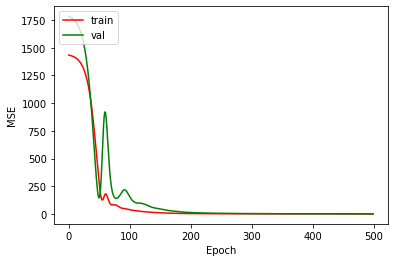

In [30]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_dlbinnedJla.png", dpi=200)

In [31]:
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])

(0.6260046362876892, 0.10592158883810043)

In [32]:
pred = neural_model.predict(z_test)
pred

array([[39.560844],
       [40.438553],
       [41.175182],
       [41.875935],
       [42.84531 ],
       [44.186283],
       [46.831062]], dtype=float32)

In [33]:
# ranz = np.random.uniform(0, np.max(z), size=31)
ranz = np.linspace(np.min(z), np.max(z),31)

# ranzinv = scalerz.transform(ranz.reshape(-1,1))

pred_random = neural_model.predict(ranz)
pred_random

array([[33.89619 ],
       [36.711193],
       [38.42097 ],
       [38.968563],
       [39.51616 ],
       [40.06375 ],
       [40.561535],
       [40.948624],
       [41.170048],
       [41.391464],
       [41.61289 ],
       [41.83431 ],
       [42.055733],
       [42.277153],
       [42.498577],
       [42.72    ],
       [42.941418],
       [43.16284 ],
       [43.384266],
       [43.605682],
       [43.827106],
       [44.048527],
       [44.269943],
       [44.491367],
       [44.71279 ],
       [44.934216],
       [45.20104 ],
       [45.574898],
       [45.98875 ],
       [46.403057],
       [46.831062]], dtype=float32)

In [34]:
# recover z
# z = scalerz.inverse_transform(z)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$



In [35]:
fake_encoded = np.zeros((1, 31))

In [36]:
print(np.shape(fake_encoded))
avg_encoded = np.mean(encoded_imgs, axis=0)
print(np.shape(avg_encoded))
print(np.shape(encoded_imgs))


(1, 31)
(31,)
(200, 31)


In [37]:
for i, avg in enumerate(avg_encoded):
    alpha = avg/z[i]
    fake_encoded[0, i] = alpha * ranz[i]

In [38]:
decoded_fake = decoder.predict(fake_encoded)
np.shape(decoded_fake)

(1, 961)

In [39]:
decoded_fake[0, :]

array([ 2.14225873e-02, -1.08029125e-02,  1.83555414e-03,  7.17979390e-04,
        8.63114023e-04,  8.01169721e-04,  8.74592224e-04,  8.12990183e-04,
        8.44334601e-04,  1.42927238e-04,  9.21491301e-04,  2.10934173e-04,
        5.01753588e-04,  3.34105396e-04,  4.11975954e-04,  4.39828524e-04,
        3.72605864e-04, -2.97832012e-05, -3.58777761e-05,  2.83074682e-04,
        1.53572211e-04,  4.30224638e-04, -3.02584158e-05,  4.52357752e-04,
        2.44508963e-04,  4.71570238e-04, -2.33642058e-05,  3.14367717e-05,
        5.37477899e-06,  5.72405057e-04,  1.26184619e-04, -1.10795246e-02,
        2.80794390e-02, -2.09340733e-03,  1.79487315e-03, -2.21248396e-04,
        3.45369976e-04,  1.28288026e-04,  2.15001346e-04,  3.17047641e-04,
        6.94058544e-04,  5.99353400e-04,  1.72150365e-04,  3.46577319e-04,
        5.11644932e-04,  3.96294170e-04,  2.44306168e-04,  5.83241810e-04,
        4.03556798e-04,  3.92763730e-04,  4.68194921e-04,  2.49248202e-04,
        6.18467224e-04,  

2.1080486e-06

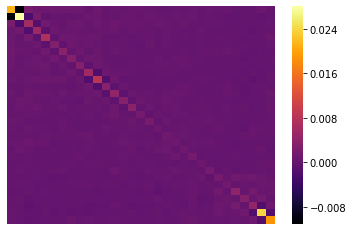

In [40]:
sns.heatmap(pd.DataFrame(decoded_fake[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
plt.savefig('fake_cov_jla.png', dpi=200)
np.min(np.abs(decoded_fake[0, :]))

-0.01084098704 0.02815552265 0.00039265133851975654
-0.011079525 0.028079439 0.00038199927
-0.011121396 0.028029485 0.0003839922


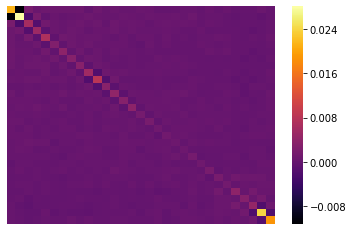

In [41]:
clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
sns.heatmap(pd.DataFrame(clean_img[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.savefig('fake_cov_clean_jla.png', dpi=200)
np.min(np.abs(clean_img[0, :]))

print(np.min(syscov), np.max(syscov), np.mean(syscov)) #checking non-negatives in the diagonal
print(np.min(decoded_fake[0,:]), np.max(decoded_fake[0,:]), np.mean(decoded_fake[0,:])) #checking non-negatives in the diagonal
print(np.min(clean_img[0,:]), np.max(clean_img[0,:]), np.mean(clean_img[0,:])) #checking non-negatives in the diagonal



In [42]:
np.savetxt("fake_binned_JLA_COVdecoded.dat", decoded_fake[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
np.savetxt("fake_binned_JLA_COVclean.dat", clean_img[0, :].reshape(31,31), delimiter= " ", header="#fake COV")

In [43]:
count = 0
new_cov =decoded_fake[0, :].reshape(31,31)

for i in range(len(new_cov)):
    for j in range(len(new_cov)):
        if np.iscomplex(new_cov[i,j]):
            print("COMPLEX")
        if new_cov[i,j] != new_cov[j,i]:
            print(i,j, end=' ')
            print(new_cov[i,j], new_cov[j,i]) 
            count+=1
            new_cov[j,i] = new_cov[i, j]

count

0 1 -0.0108029125 -0.011079525
0 2 0.0018355541 0.0019338873
0 3 0.0007179794 0.0006945982
0 4 0.000863114 0.0006584784
0 5 0.0008011697 0.0007913977
0 6 0.0008745922 0.0010638068
0 7 0.0008129902 0.0009511527
0 8 0.0008443346 0.00073434756
0 9 0.00014292724 0.00039600264
0 10 0.0009214913 0.00055268104
0 11 0.00021093417 8.698991e-05
0 12 0.0005017536 0.0005693608
0 13 0.0003341054 0.00025476178
0 14 0.00041197595 0.00016955228
0 15 0.00043982852 0.0003639303
0 16 0.00037260586 0.00057579397
0 17 -2.9783201e-05 0.00044853444
0 18 -3.5877776e-05 0.0003624452
0 19 0.00028307468 0.00042476825
0 20 0.00015357221 0.00014828393
0 21 0.00043022464 0.00038245332
0 22 -3.0258416e-05 -0.00019769199
0 23 0.00045235775 0.0002075879
0 24 0.00024450896 5.0019356e-05
0 25 0.00047157024 0.00019945877
0 26 -2.3364206e-05 -8.095674e-05
0 27 3.143677e-05 8.99749e-05
0 28 5.374779e-06 0.00026056342
0 29 0.00057240506 0.00024138938
0 30 0.00012618462 0.00027980117
1 2 -0.0020934073 -0.0023197313
1 3 0.001

465

In [44]:
np.savetxt("fake_binned_JLA_COVdecodedsim.dat", new_cov, delimiter= " ", header="#fake COV")

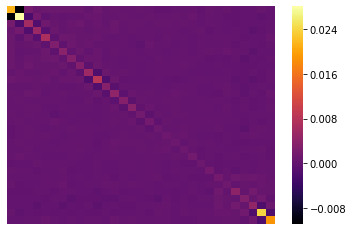

In [45]:
sns.heatmap(pd.DataFrame(new_cov), fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [46]:
fake_data = np.concatenate((ranz.reshape(-1,1), pred_random), axis=1)


np.savetxt("fake_binned_JLA.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu")
fake_data


array([[1.00000000e-02, 3.38961906e+01],
       [5.30000000e-02, 3.67111931e+01],
       [9.60000000e-02, 3.84209709e+01],
       [1.39000000e-01, 3.89685631e+01],
       [1.82000000e-01, 3.95161591e+01],
       [2.25000000e-01, 4.00637512e+01],
       [2.68000000e-01, 4.05615349e+01],
       [3.11000000e-01, 4.09486237e+01],
       [3.54000000e-01, 4.11700478e+01],
       [3.97000000e-01, 4.13914642e+01],
       [4.40000000e-01, 4.16128883e+01],
       [4.83000000e-01, 4.18343086e+01],
       [5.26000000e-01, 4.20557327e+01],
       [5.69000000e-01, 4.22771530e+01],
       [6.12000000e-01, 4.24985771e+01],
       [6.55000000e-01, 4.27200012e+01],
       [6.98000000e-01, 4.29414177e+01],
       [7.41000000e-01, 4.31628418e+01],
       [7.84000000e-01, 4.33842659e+01],
       [8.27000000e-01, 4.36056824e+01],
       [8.70000000e-01, 4.38271065e+01],
       [9.13000000e-01, 4.40485268e+01],
       [9.56000000e-01, 4.42699432e+01],
       [9.99000000e-01, 4.44913673e+01],
       [1.042000

In [47]:
errors = np.sqrt(np.abs(np.diagonal(syscov)))
fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))

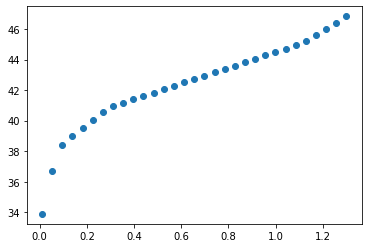

In [48]:
plt.scatter(ranz, pred_random)

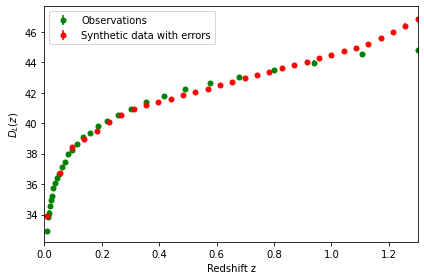

In [49]:
plt.errorbar(z, dl, yerr=errors, fmt='g.', markersize=10, label='Observations')
plt.errorbar(ranz, pred_random, 
             yerr=fakeerrors, fmt='r.', markersize=10., label='Synthetic data with errors')

# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$D_L(z)$")
plt.xlim(0, np.max(z))
plt.tight_layout()
plt.legend()
# plt.savefig('fake_vs_binned_jla.png', dpi=200)

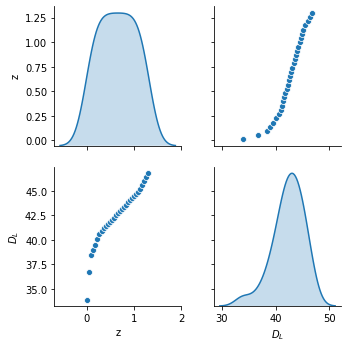

In [50]:
fake_datadf = pd.DataFrame(fake_data, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf, diag_kind="kde")
# plt.savefig('fake_binned_jla.png')